current state: start


100%|██████████| 5/5 [00:00<00:00, 1320.29it/s]


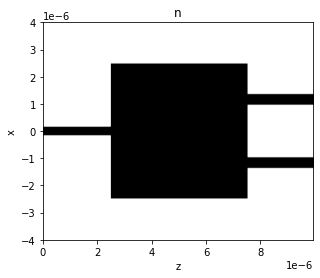

current state: mode_solving


100%|██████████| 5/5 [00:00<00:00, 832.24it/s]


current state: finished_modes
current state: layer_propagating


4it [00:00, 4700.82it/s]


current state: finished_layer
current state: network_building
current state: finished_network
current state: field_propagating


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


current state: finished


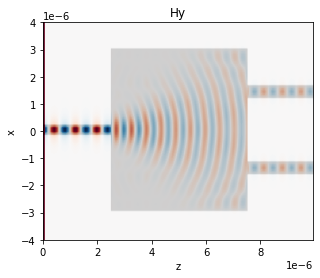

current state: field_propagating


100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


current state: finished


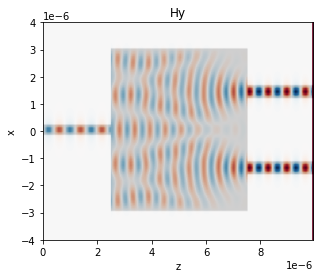

In [1]:
import emepy
from emepy.eme import Layer, EME
from emepy.mode import Mode
from emepy.fd import MSEMpy
import numpy as np
from matplotlib import pyplot as plt
from emepy.tools import Si, SiO2

# Geometric parameters
wavelength = 1.55e-6  # Wavelength
num_inputs = 1
num_outputs = 2

input_width = 0.4e-6
output_width = 0.4e-6
input_gap = 2e-6
output_gap = 2e-6
input_length = 2e-6
output_length = 2e-6
mmi_width = 5e-6
mmi_length = 5e-6
input_taper_width = 1e-6
input_taper_length = 0.5e-6
input_taper_num_steps = 1
output_taper_width = 1e-6
output_taper_length = 0.5e-6
output_taper_num_steps = 1

thickness = 0.22 * 1e-6
mesh = 100  # Number of mesh points
core_index = Si(wavelength * 1e6)  # Silicon core
cladding_index = SiO2(wavelength * 1e6)  # Oxide cladding
num_modes_mmi = 20
num_modes_input = 3
num_modes_output = 10
x = np.linspace(-4e-6, 4e-6, mesh)
PML = True

# Create simulation
eme = EME()

# Create source input
starting_center = -0.5 * (num_inputs - 1) * (input_gap + input_width)
n_input = np.ones(mesh) * cladding_index
for inp in range(num_inputs):
    center = starting_center + inp * (input_gap + input_width)
    left_edge = center - 0.5 * input_width
    right_edge = center + 0.5 * input_width
    n_input = np.where((left_edge <= x) * (x <= right_edge), core_index, n_input)

input_channel = MSEMpy(
    wavelength,
    width=None,
    thickness=thickness,
    cladding_index=cladding_index,
    num_modes=num_modes_input,
    mesh=mesh,
    x=x,
    y=x,
    n=n_input,
    PML=PML,
)

eme.add_layer(Layer(input_channel, num_modes_input, wavelength, input_length))

# Create taper into MMI
for i in range(input_taper_num_steps):
    starting_center = -0.5 * (num_inputs - 1) * (input_gap + input_width)
    n_input = np.ones(mesh) * cladding_index
    for out in range(num_inputs):
        center = starting_center + out * (input_gap + input_width)
        width = input_width + (input_taper_width - input_width) * (i / input_taper_num_steps)
        left_edge = center - 0.5 * width
        right_edge = center + 0.5 * width
        n_input = np.where((left_edge <= x) * (x <= right_edge), core_index, n_input)

    input_taper_channel = MSEMpy(
        wavelength,
        width=None,
        thickness=thickness,
        cladding_index=cladding_index,
        num_modes=num_modes_input,
        mesh=mesh,
        x=x,
        y=x,
        n=n_input,
        PML=PML,
    )

    eme.add_layer(Layer(input_taper_channel, num_modes_input, wavelength, input_taper_length / input_taper_num_steps))

# Create mmi middle
n_middle = np.ones(mesh) * cladding_index
left_edge = -0.5 * mmi_width
right_edge = 0.5 * mmi_width
n_middle = np.where((left_edge <= x) * (x <= right_edge), core_index, n_middle)

middle = MSEMpy(
    wavelength,
    width=None,
    thickness=thickness,
    cladding_index=cladding_index,
    num_modes=num_modes_mmi,
    mesh=mesh,
    x=x,
    y=x,
    n=n_middle,
    PML=PML,
)

eme.add_layer(Layer(middle, num_modes_mmi, wavelength, mmi_length))

# Create taper out of MMI
for i in range(output_taper_num_steps)[::-1]:
    starting_center = -0.5 * (num_outputs - 1) * (output_gap + output_width)
    n_output = np.ones(mesh) * cladding_index
    for out in range(num_outputs):
        center = starting_center + out * (output_gap + output_width)
        width = output_width + (output_taper_width - output_width) * (i / output_taper_num_steps)
        left_edge = center - 0.5 * width
        right_edge = center + 0.5 * width
        n_output = np.where((left_edge <= x) * (x <= right_edge), core_index, n_output)

    output_taper_channel = MSEMpy(
        wavelength,
        width=None,
        thickness=thickness,
        cladding_index=cladding_index,
        num_modes=num_modes_output,
        mesh=mesh,
        x=x,
        y=x,
        n=n_output,
        PML=PML,
    )

    eme.add_layer(
        Layer(output_taper_channel, num_modes_output, wavelength, output_taper_length / output_taper_num_steps)
    )


# Create output
starting_center = -0.5 * (num_outputs - 1) * (output_gap + output_width)
n_output = np.ones(mesh) * cladding_index
for out in range(num_outputs):
    center = starting_center + out * (output_gap + output_width)
    left_edge = center - 0.5 * output_width
    right_edge = center + 0.5 * output_width
    n_output = np.where((left_edge <= x) * (x <= right_edge), core_index, n_output)

output_channel = MSEMpy(
    wavelength,
    width=None,
    thickness=thickness,
    cladding_index=cladding_index,
    num_modes=num_modes_output,
    mesh=mesh,
    x=x,
    y=x,
    n=n_output,
    PML=PML,
)

eme.add_layer(Layer(output_channel, num_modes_output, wavelength, output_length))

# Add a monitor
monitor = eme.add_monitor(axes="xyz", mesh_z=200)

# Visualize the layout
plt.figure()
eme.draw()
plt.show()

eme.propagate(left_coeffs=[1],right_coeffs=[])

plt.figure()
monitor.visualize(axes="xz")
plt.show()

eme.propagate(left_coeffs=[],right_coeffs=[1])

plt.figure()
monitor.visualize(axes="xz")
plt.show()